## INSTALAR LOS PAQUETES NECESARIOS

In [ ]:
!pip install pandas
!pip install seaborn
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score, adjusted_rand_score, davies_bouldin_score, calinski_harabasz_score
from collections import defaultdict

## DESCRIPCIÓN DE LOS DATOS

### MNIST

El conjunto de datos _MNIST_ es un dataset ampliamente utilizado en el ámbito del aprendizaje automático, el cual está compuesto por un conjunto de imágenes de dígitos escritos a mano, siendo las posibilidades los números del cero al nueve.

Este dataset consta de 70.000 instancias distribuidas en 2 subconjuntos. Un subconjunto _train_ de 60.000 instancias y un subconjunto _test_ de 10.000 instancias.

### DESCRIPCIÓN DE LAS INSTANCIAS

Cada instancia en MNIST es una imagen de 28x28 píxeles a escala de grises. Por lo tanto, cada imagen contiene 784 píxeles. Cada uno de los píxeles se representa con un valor numérico entre 0 y 255 que indica la intensidad del gris.

De este modo, se puede representar cada imagen con un vector numérico de 784 posiciones. En el contexto del aprendizaje automático, los 784 valores de ese vector se tratarán como atributos, que irán acompañados de un valor extra que determinará la clase correspondiente. La clase dictamina cuál es el número representado en cada una de las imágenes.

## CARGAR LOS DATOS

Los datos han sido obtenidos de la plataforma _Kaggle_ en formato CSV. A continuación se procede a importarlos en este _Jupyter Notebook_ y a cargarlos en formato de dataset mediante la librería _pandas_. Los datos serán distribuidos en dos variables, una que contendrá las 60.000 instancias de _train_ y otro que contendrá las 10.000 instancias de _test_.

In [2]:
train_path = "mnist_train.csv"
test_path = "mnist_test.csv"

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

## SEPARACIÓN DE LA CLASE Y LOS ATRIBUTOS

Para que durante el proceso de clustering el valor de la clase no interfiera, se procede a almacenar en las variables _classes_ y _classes_test_ los valores supervisados de clase. A su misma vez, esos valores se retiran de los conjuntos de datos _train_ y _test_.

In [3]:
classes = train_data['label'].copy()
train_data.drop('label', axis=1, inplace=True)

classes_test = test_data['label'].copy()
test_data.drop('label', axis=1, inplace=True)

## REPRESENTACIÓN GRÁFICA DEL NÚMERO DE INSTANCIAS POR CLASE

Para poder certificar que la muestra de datos que se está empleando es suficientemente representativa, se procede a la representación gráfica del número de instancias por cada valor de clase. De esta forma, tras conseguir un gráfico donde el número de instancias es similar para cada uno de los valores de la clase, queda garantizada la significancia de los resultados que se consigan a continuación.

<BarContainer object of 10 artists>

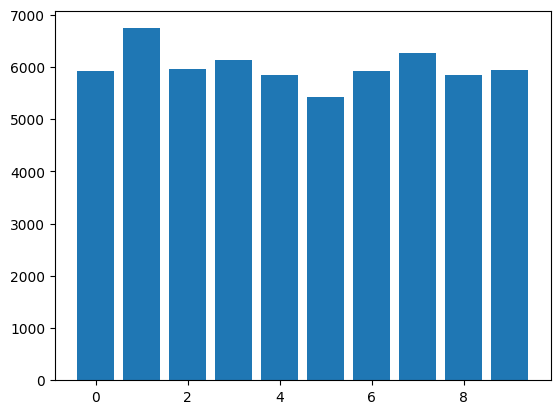

In [4]:
plt.bar(classes.value_counts().index, classes.value_counts())

## VISUALIZACIÓN DE LA IMAGEN CORRESPONDIENTE A LA INSTANCIA EN LA POSICION "I"

A continuación se define una función de _Python_ que muestra la imagen contenida en la instancia "_i_" junto con el valor de clase supervisado que le corresponde.

In [5]:
def visualize(i):
    some_digit = train_data.iloc[i]
    plt.imshow(some_digit.values.reshape(28, 28))
    print('label', classes.iloc[i])

label 9


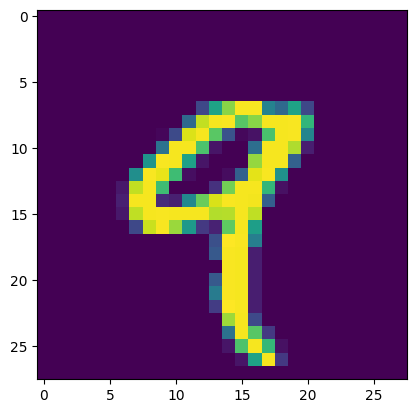

In [6]:
visualize(4)

## PROCESO DE CLUSTERING

Tras hacer un breve sondeo por los datos cargados y cerciorar que son lo suficientemente representativos, se procede a iniciar el proceso de clustering. No obstante, previo a agrupar los datos, se procede a obtener dos muestras extra en las cuales la dimensión de los atributos se va a ver reducida por diferentes técnicas. De este modo, además de tener la posibilidad de ver los datos de manera gráfica, puede que se obtengan mejores resultados a la hora de dividirlos.

Este proceso tiene sentido hacerlo antes de aplicar el algoritmo de clustering, para que los datos con los que trabaje el algoritmo sean menos complejos en cuestiones de dimensión. Aplicar una reducción de dimensionalidad en los datos _a posteriori_ no tendría demasiado sentido, únicamente serviría para poder visualizarlos.

Ciertamente, cuando la dimensión de los datos se ve reducida, se pierde algo de información, por lo tanto, si los recursos para el proceso de clustering no son limitados, lo idóneo sería emplear los datos sin ningún tipo de reducción, aunque en casos excepcionales una reducción puede suponer la eliminación de ruido en las instancias y dar lugar a una mejor agrupación.

### REDUCCIÓN EN LA DIMENSIÓN DE LOS DATOS (PCA)

_PCA_ identifica las relaciones lineales entre las variables originales y crea un nuevo conjunto de variables, llamadas componentes principales, que son combinaciones lineales de las variables originales. Estos componentes capturan la mayor parte de la variabilidad en los datos, lo que permite visualizar y analizar datos complejos de manera más efectiva, eliminar redundancias y ruido y facilitar la detección de patrones y tendencias importantes.

In [7]:
print('Original dimension: ',train_data.shape)
# Reduce the dimensions to be able to see it: PCA
pca = PCA(n_components=2, random_state=0)
pca.fit(train_data)
# 2 dimension base adaptation
train_pca = pca.transform(train_data)
print('PCA adapted dimension: ',train_pca.shape)

Original dimension:  (60000, 784)
PCA adapted dimension:  (60000, 2)


### REDUCCIÓN EN LA DIMENSIÓN DE LOS DATOS (t-SNE)

_t-SNE_ se centra en preservar las similitudes entre los puntos de datos originales mientras reduce la dimensionalidad. A diferencia de _PCA_, _t-SNE_ es especialmente efectivo para resaltar relaciones no lineales y grupos en los datos, lo que lo hace útil para descubrir estructuras complejas en conjuntos de datos.

In [8]:
print('Original dimension: ',train_data.shape)
train_tsne = TSNE(n_components=2, random_state=0).fit_transform(train_data)
print('TSNE adapted dimension: ',train_tsne.shape)

Original dimension:  (60000, 784)
TSNE adapted dimension:  (60000, 2)


Reducir las dimensiones implica perder alguna información, ya que varios puntos del espacio de datos pueden llegar a converger en uno mismo, haciendo imperceptible la diferencia entre sí. Aun así, puede que después de reducir la dimensión de los datos, el resultado de clustering sea de mejor calidad.

### APLICAR EL ALGORITMO DE CLUSTERING K-MEANS

El algoritmo a emplear en este caso es _K-Means_. El algoritmo _K-Means_ es un algoritmo de clustering no supervisado que agrupa un conjunto de datos en _k_ grupos, donde _k_ es un número predefinido. El objetivo del algoritmo es minimizar la suma de las distancias entre los puntos de cada grupo y el centroide del grupo, donde el centroide es el punto que representa el grupo.

Para su uso, en este caso, se ha empleado la librería _skleanr_ de _Python_. Para aplicar este algoritmo de clustering a través de la librería _skleanr_ únicamente se ha de indicar el número de clústeres en los que se desean agrupar los datos y proporcionar los datos de entrada, por supuesto.

Adicionalmente, se puede añadir la opción _random-state_ que conlleva que el sistema inicie el algoritmo siempre de la misma forma, siendo esta aleatoria. Finalmente, con el uso de _n_init_ el algoritmo se inicia en más de una ocasión y devuelve los resultados de la mejor ejecución.

**APLICAR A LOS DATOS SIN REDUCCIÓN DE DIMENSIONALIDAD**

In [9]:
num_clusters=10
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init=10)
kmeans.fit(train_data)
kmeansLabels = kmeans.predict(train_data) # Get the cluster label for each train instance

**APLICAR A LOS DATOS REDUCIDOS CON PCA**

In [10]:
num_clusters=10
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init=10)
kmeans.fit(train_pca)
kmeansLabels_pca = kmeans.predict(train_pca) # Get the cluster label for each train instance

**APLICAR A LOS DATOS REDUCIDOS CON TSNE**

In [11]:
num_clusters=10
kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init=10)
kmeans.fit(train_tsne)
kmeansLabels_tsne = kmeans.predict(train_tsne) # Get the cluster label for each train instance

### VISUALIZACIÓN DE N INSTANCIAS EN UN ESPACIO REDUCIDO 2D (PCA)

A continuación se representan los resultados del clustering de manera gráfica. Algo a tener cuenta es que a estos datos se les ha aplicado _PCA_ previo al proceso de clustering de tal forma que la dimensión de las instancias es dos.

En la gráfica, el color de los puntos representa el clúster que le ha sido asignado y la etiqueta numérica representa la clase real de la instancia. Adicionalmente, se muestran con cruces rojas los puntos establecidos para los centroides.

In [1]:
# Draw just some instances
samples = 300
# Draw instances on the space, color: cluster, numeric label: class
# Color of the point: cluster
sc = plt.scatter(train_pca[:samples,0],train_pca[:samples,1], cmap=plt.cm.get_cmap('nipy_spectral', 10),c=kmeansLabels_pca[:samples])
plt.colorbar()
# Numeric label: class
for i in range(samples):
    plt.text(train_pca[i,0],train_pca[i,1], classes[i])

centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100,
linewidths=3, color='red')

NameError: name 'plt' is not defined

### VISUALIZACIÓN DE N INSTANCIAS EN UN ESPACIO REDUCIDO 2D (t-SNE)

Al igual que en el caso anterior, la dimensión de los datos ha sido reducida, pero esta vez con _t-SNE_. El color de los puntos representa aquí también el clúster que se le ha sido asignado y la etiqueta numérica, la clase real. Adicionalmente, se muestran con cruces rojas los puntos establecidos para los centroides.

C:\Users\Sergio\AppData\Local\Temp\ipykernel_8660\254162152.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sc = plt.scatter(train_tsne[:samples,0],train_tsne[:samples,1], cmap=plt.cm.get_cmap('nipy_spectral', 10),c=kmeansLabels_tsne[:samples])


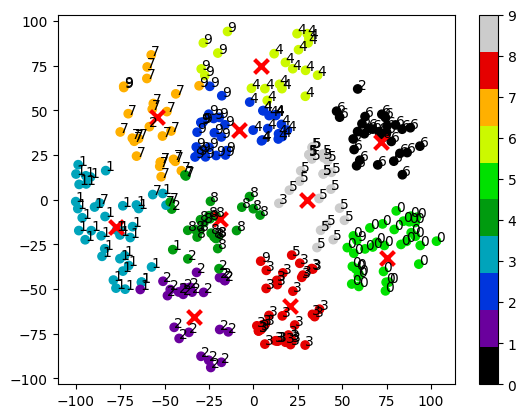

In [13]:
# Draw just some instances
samples = 300
# Draw instances on the space, color: cluster, numeric label: class
# Color of the point: cluster
sc = plt.scatter(train_tsne[:samples,0],train_tsne[:samples,1], cmap=plt.cm.get_cmap('nipy_spectral', 10),c=kmeansLabels_tsne[:samples])
plt.colorbar()
# Numeric label: class
for i in range(samples):
    plt.text(train_tsne[i,0],train_tsne[i,1], classes[i])

centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100,
linewidths=3, color='red')

Una vez representados los datos con los dos tipos de reducciones aplicadas (_t-SNE_ y _PCA_), se puede observar que la técnica _t-SNE_ proporciona mejores resultados. Sin embargo, esta técnica realiza un cambio de base vectorial en las instancias y eso implica que tiene que guardar ese cambio y aplicarlo cada vez que una instancia nueva entra en el sistema, lo cual puede llegar a ser algo tedioso en algunas situaciones.

### VISUALIZACIÓN DE 4 INSTANCIAS POR CLUSTER

A continuación se hace una exploración _post-clustering_ donde se visualizan cuatro instancias por clúster (cada fila representa un clúster). Si el algoritmo es lo suficientemente bueno, la mayoría de las imágenes contenidas en un mismo clúster (fila) deberían de representar el mismo número.

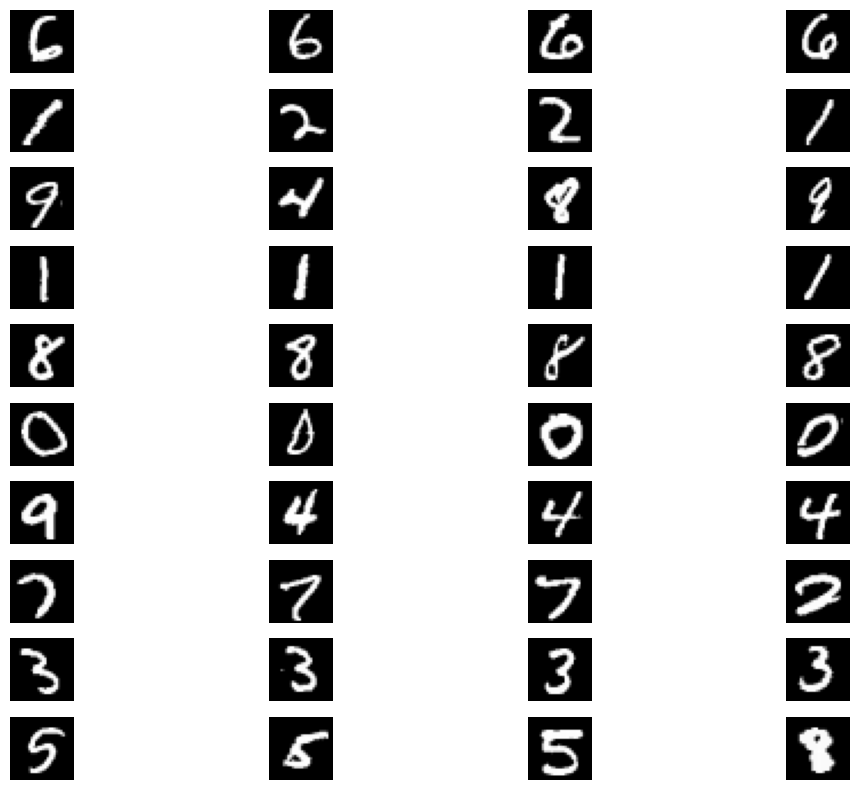

In [14]:
cluster_labels=kmeans.labels_
clusters = {cluster_id: [] for cluster_id in range(num_clusters)}

for image_index, cluster_label in enumerate(cluster_labels):
    clusters[cluster_label].append(train_data.iloc[image_index])

n_images=4
plt.figure(figsize=(12, 8))
for cluster_id in range(num_clusters):
    cluster_images = clusters[cluster_id]

    if len(cluster_images) < n_images:
        continue
    random_indices = np.random.choice(len(cluster_images), n_images, replace=False)

    for i, random_index in enumerate(random_indices):
        image_data = cluster_images[random_index].values.reshape((28,28))
        plt.subplot(num_clusters, n_images, cluster_id * n_images + i + 1)
        plt.imshow(image_data, cmap='gray')
        plt.axis('off')

plt.tight_layout()
plt.show()

### CREAR LA MATRIZ DE CONFUSIÓN

Para realizar una evaluación _class to cluster_ se precisa de una matriz de confusión. A continuación se grafican matrices de confusión para los diferentes conjuntos de instancias obtenidos en los anteriores apartados (con reducción de dimensionalidad o sin ella).

Con la intención de hacer la matriz de confusión más agradable a la vista y más comprensible, se representarán en formato _heatmap_.

MATRIZ DE CONFUSIÓN DE LOS DATOS SIN REDUCCIONES

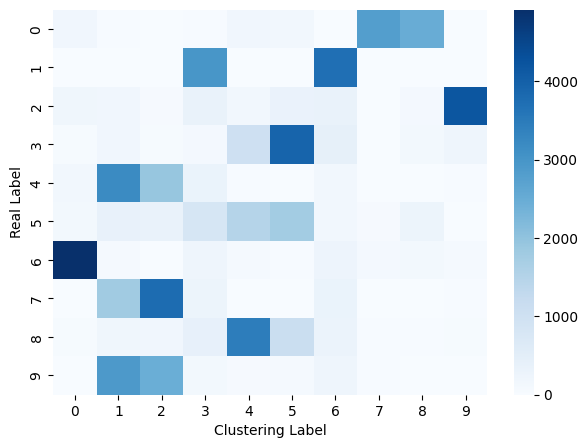

In [15]:
# The attribute generated by K-means is an integer; we need to convert them to strings
to_string = lambda x: str(x)

# Get the confusion matrix (Class to clustering evaluation)
cm = confusion_matrix(np.vectorize(to_string)(classes), np.vectorize(to_string)(kmeansLabels))

# Create a heatmap from the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, fmt="d", annot=False, cmap='Blues')
plt.ylabel('Real Label')
plt.xlabel('Clustering Label')

# Draw the heatmap
plt.show()


MATRIZ DE CONFUSIÓN DE LOS DATOS CON REDUCCIONES PCA

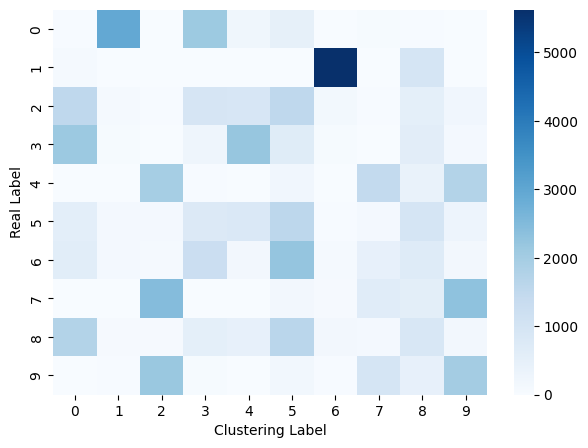

In [16]:
# The attribute generated by K-means is an integer; we need to convert them to strings
to_string = lambda x: str(x)

# Get the confusion matrix (Class to clustering evaluation)
cm = confusion_matrix(np.vectorize(to_string)(classes), np.vectorize(to_string)(kmeansLabels_pca))

# Create a heatmap from the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, fmt="d", annot=False, cmap='Blues')
plt.ylabel('Real Label')
plt.xlabel('Clustering Label')

# Draw the heatmap
plt.show()

MATRIZ DE CONFUSIÓN DE LOS DATOS CON REDUCCIONES TSNE

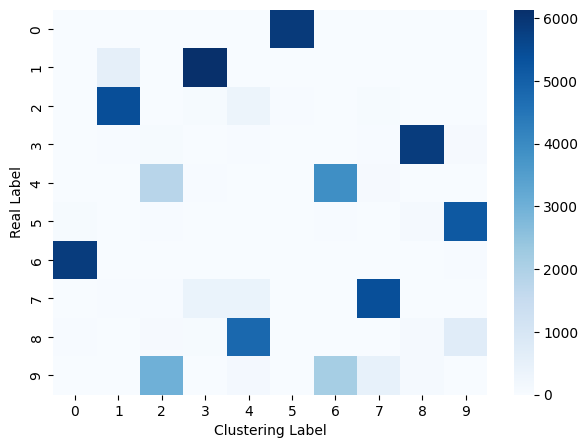

In [17]:
# The attribute generated by K-means is an integer; we need to convert them to strings
to_string = lambda x: str(x)

# Get the confusion matrix (Class to clustering evaluation)
cm = confusion_matrix(np.vectorize(to_string)(classes), np.vectorize(to_string)(kmeansLabels_tsne))

# Create a heatmap from the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, fmt="d", annot=False, cmap='Blues')
plt.ylabel('Real Label')
plt.xlabel('Clustering Label')

# Draw the heatmap
plt.show()

### REASIGNAR LOS _LABELS_ PARA CONSEGUIR MAYOR CORRELACIÓN ENTRE LAS ETIQUETAS DE CLUSTERING Y LAS REALES Y EVALUAR LOS RESULTADOS

En la matriz de confusión aparecen las etiquetas reales y también las etiquetas de clustering. No obstante, en el caso de las etiquetas de clustering, la etiqueta de valor 1, no necesariamente contendrá las imágenes del dígito 1. Por ello, se han de reasignar las etiquetas para que se correspondan con la clase, de forma que la matriz tome más sentido en la diagonal.

La función definida a continuación realiza el trabajo de reasignación de etiquetas y se empleará para crear las matrices de confusión para todos los casos, pero esta vez con las etiquetas debidamente reasignadas.

En el caso de que el dígito más frecuente (moda) sea el mismo en dos de los clústeres que han sido generados por el algoritmo,  a la hora de visualizarlo en la matriz de confusión, las instancias de esos dos clústeres se verán agrupadas en una misma columna. A pesar de que a nivel conceptual no es lo más adecuado, para hacer el cálculo del error cometido no es un inconveniente.

Finalmente, al pie de cada una de las matrices aparecerá el error propio de las mismas, que consiste principalmente en la división del número de instancias correctamente clasificadas por el número total de instancias. Se multiplica por cien para convertirlo en un porcentaje.

In [18]:
def remap_labels(original_labels, cluster_labels):
    mapping = {}
    for cluster_label in np.unique(cluster_labels):
        original_label = np.argmax(np.bincount(original_labels[cluster_labels == cluster_label]))
        mapping[cluster_label] = original_label

    remapped_labels = np.vectorize(mapping.get)(cluster_labels)
    return remapped_labels


REASIGNAR LAS ETIQUETAS DEL CLUSTERING CON LOS DATOS SIN REDUCIR

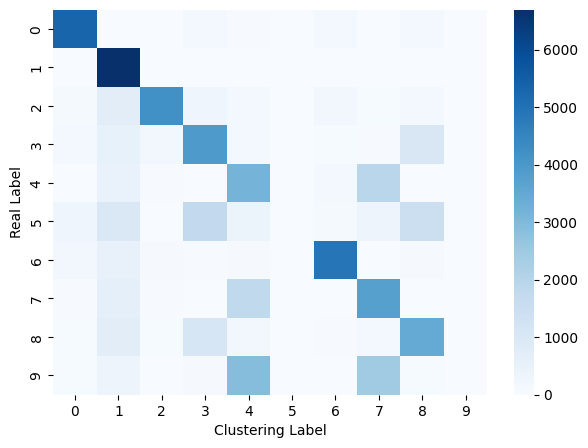

The error made in this clustering is: 40.89666666666667 %


In [19]:
remapped_labels = remap_labels(classes, kmeansLabels)

cm = confusion_matrix (classes, remapped_labels)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, fmt="d", annot=False, cmap='Blues')
plt.ylabel('Real Label')
plt.xlabel('Clustering Label')
plt.show()

error = 100 * (1 - accuracy_score(classes, remapped_labels))
print("The error made in this clustering is:", error,"%")

REASIGNAR LAS ETIQUETAS DEL CLUSTERING CON LOS DATOS REDUCIDOS CON PCA

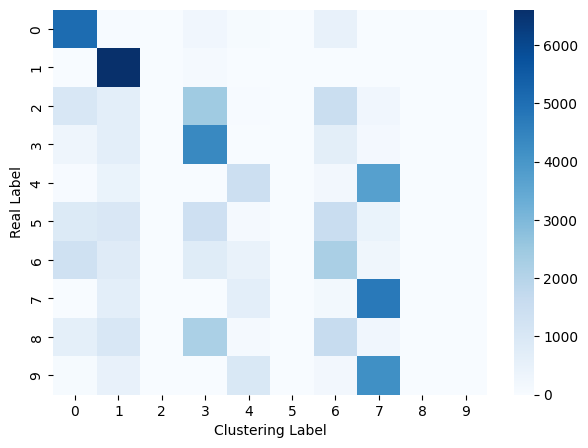

The error made in this clustering is: 59.166666666666664 %


In [20]:
remapped_labels = remap_labels(classes, kmeansLabels_pca)

cm = confusion_matrix (classes, remapped_labels)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, fmt="d", annot=False, cmap='Blues')
plt.ylabel('Real Label')
plt.xlabel('Clustering Label')
plt.show()

error = 100 * (1 - accuracy_score(classes, remapped_labels))
print("The error made in this clustering is:", error,"%")

REASIGNAR LAS ETIQUETAS DEL CLUSTERING CON LOS DATOS REDUCIDOS CON TSNE

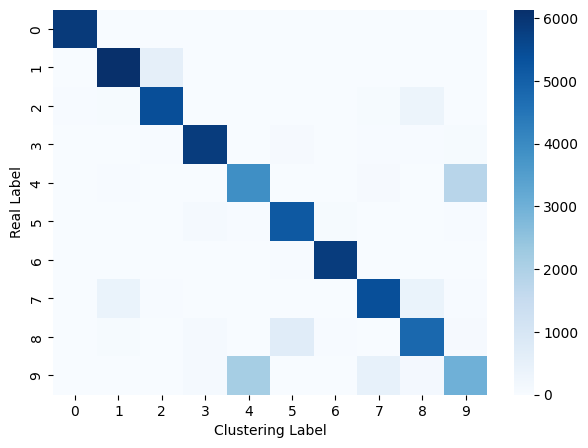

The error made in this clustering is: 14.426666666666666 %


In [21]:
remapped_labels = remap_labels(classes, kmeansLabels_tsne)

cm = confusion_matrix (classes, remapped_labels)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, fmt="d", annot=False, cmap='Blues')
plt.ylabel('Real Label')
plt.xlabel('Clustering Label')
plt.show()

error = 100 * (1 - accuracy_score(classes, remapped_labels))
print("The error made in this clustering is:", error,"%")

**NOTA:**
La opción que mejores resultados ha obtenido ha sido la opción reducida con _t-SNE_, por lo tanto, a partir de este instante se trabajará con ese conjunto de datos reducido.

## BUSCAR EL NÚMERO DE CLUSTERS QUE MINIMIZA EL ERROR COMETIDO EN LA MATRIZ DE CONFUSIÓN

En el conjunto de datos _MNIST_ es evidente que el número de clústeres a conseguir es 10. Sin embargo, puede que en otros casos el número de clústeres sea desconocido y nada evidente. Por lo tanto, es conveniente probar con diferentes números de clústeres y analizar las matrices de confusión y su error para conseguir el número de clústeres óptimo.

In [22]:
# Define a list of cluster numbers to test
num_clusters_to_try = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]

min_error = 100
best_num_clust = None

# Iterate over different numbers of clusters
for num_clusters in num_clusters_to_try:
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(train_tsne)
    cluster_labels = kmeans.predict(train_tsne)

    remapped_labels = remap_labels(classes, cluster_labels)

    # Calculate classification error
    error = 100 * (1 - accuracy_score(classes, remapped_labels))

    if error < min_error:
        min_error = error
        best_num_clust = num_clusters


print(f"The optimum number of clusters is:", best_num_clust)
print(f"The minimal classification error is:", round(min_error,2), "%")



C:\Users\Sergio\PycharmProjects\Clustering_MNIST\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Sergio\PycharmProjects\Clustering_MNIST\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Sergio\PycharmProjects\Clustering_MNIST\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Sergio\PycharmProjects\Clustering_MNIST\venv\lib\site-packages\sklearn\cluster\

The optimum number of clusters is: 14
The minimal classification error is: 10.22 %


## EVALUAR LOS RESULTADOS CONSEGUIDOS CON DIFERENTES MÉTRICAS

A continuación se presentan diferentes métricas de evaluación tanto internas como externas. A excepción del _ARI_ el resto de métricas son de evaluación interna, mientras que el _ARI_ es una métrica de evaluación externa. La principal diferencia es el uso de información externa para la evaluación del proceso de clustering, en el caso de las métricas de evaluación externa emplean el valor real de las etiquetas de clase para estimar la calidad del resultado, mientras que las métricas de evaluación interna no precisan de los valores reales de la clase para la estimación de la calidad.

En cuanto a _Calinski-Harabasz score_ y _Davies-Bouldin score_ los valores que se contemplan no son limitados, será idóneo un valor de _Calinski-Harabasz score_ alto y un valor de _Davies-Bouldin score_ bajo. Respecto a los valores de _ARI_ y _Silhouette- score_, están comprendidos entre 1 y -1, siendo en ambos casos 1 el mejor valor y -1 el peor.

In [23]:
### CALINSKI- HARABASZ SCORE ###

calinski_score = calinski_harabasz_score(train_tsne, kmeansLabels_tsne)
print("Calinski score:", round(calinski_score,3))

### DAVIES-BOULDIN SCORE ###

davies_score = davies_bouldin_score(train_tsne, kmeansLabels_tsne)
print("Davies_score:", round(davies_score,3))

### SILHOUETTE SCORE ###

silhouette_avg = silhouette_score(train_tsne, kmeansLabels_tsne)
print("Silhouette_score:", round(silhouette_avg,3))


### ADJUSTED RAND INDEX (ARI) ###

ari = adjusted_rand_score(classes, kmeansLabels_tsne)
print("ARI:", round(ari,3))

Calinski score: 65272.899
Davies_score: 0.783
Silhouette_score: 0.423
ARI: 0.756


## AGRUPACIÓN DE UNA NUEVA INSTANCIA EN LOS CLÚSTERES YA DEFINIDOS CON ANTERIORIDAD

Finalmente, se introducirá en el sistema una nueva instancia del subconjunto de datos _test_ para que esta sea agrupada dentro de un clúster de los definidos anteriormente. El código mostrará el clúster predicho por el sistema para esa instancia y el valor real, de modo que se ve fácilmente si el sistema lo ha agrupado de manera correcta o no.

Algo a tener en cuenta es que los datos de _train_ con los que se ha aplicado el algoritmo _K-Means_ estaban reducidos mediante _t-SNE_. Por lo tanto, cuando se quiere introducir una nueva instancia en el sistema, se debe de conseguir la proyección de esa instancia en el espacio de dimensionalidad reducida que se creó previamente. La clase de _TSNE_ por defecto no tiene una función que realice esa proyección. Por ello, para este último apartado se cogerá el conjunto de datos al completo y se hará la reducción t-SNE a todos los datos, para después separarlos en _train_ y _test_, de modo que ambos conjuntos compartirán el espacio de datos.

Cuando ambos conjuntos comparten espacio, no hay problema de asignar instancias nuevas a los clústeres previamente creados.

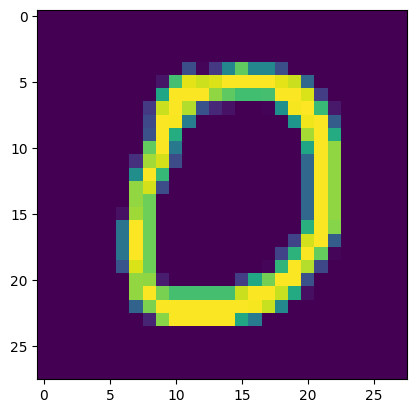

In [24]:
def visualize(i):
    some_digit = test_data.iloc[i]
    plt.imshow(some_digit.values.reshape(28, 28))

visualize(10)

In [25]:
# Combine train and test data in order to apply TSNE technique
traintest_data = np.vstack((train_data, test_data))
tsne_space = TSNE(n_components=2, random_state=0).fit_transform(traintest_data)
train_tsne = tsne_space[:len(train_data)]
test_tsne = tsne_space[len(train_data):]

# Apply K-means algorithm
kmeans = KMeans(n_clusters=10, random_state=0, n_init=10)
kmeans.fit(train_tsne)
kmeansLabels_tsne = kmeans.predict(train_tsne) # Get the cluster label for each train instance

predicted_cluster = kmeans.predict(test_tsne[10].reshape(1, -1))
print("The predicted cluster is ", predicted_cluster)

original_label = np.argmax(np.bincount(classes[kmeans.labels_ == predicted_cluster]))
print("So, the prediction for the image is ", original_label)

The predicted cluster is  [8]
So, the prediction for the image is  0


Se puede ver que para la nueva instancia se ha predicho el octavo clúster. Como en el octavo clúster la mayoría de las imágenes se corresponden con el dígito 0 en este caso también la instancia a clasificar se colocara en ese clúster.